# Bayesian Tomatoes

<div class="banner-container">
<img src="http://content7.flixster.com/movie/11/16/81/11168101_det.jpg" width=180>
</div>

<div class="banner-container">
<img src="http://content6.flixster.com/movie/11/15/15/11151508_det.jpg" width=180>
</div>

<div class="banner-container">
<img src="http://content9.flixster.com/movie/11/16/61/11166199_det.jpg" width=180>
</div>

<div class="clear"> </div>

<style type="text/css">
.banner-container {
height:350px;
margin-left: 30px;
float:left;
}
.clear {
clear:both;
}
</style>

In this assignment, you'll be analyzing movie reviews from [Rotten Tomatoes](http://www.rottentomatoes.com). This assignment will cover:

 * Working with web APIs
 * Making and interpreting predictions from a Bayesian perspective
 * Using the Naive Bayes algorithm to predict whether a movie review is positive or negative
 * Using cross validation to optimize models

Useful libraries for this assignment

* [numpy](http://docs.scipy.org/doc/numpy-dev/user/index.html), for arrays
* [scikit-learn](http://scikit-learn.org/stable/), for machine learning
* [json](http://docs.python.org/2/library/json.html) for parsing JSON data from the web.
* [pandas](http://pandas.pydata.org/), for data frames
* [matplotlib](http://matplotlib.org/), for plotting
* [requests](http://docs.python-requests.org/en/latest/), for downloading web content

In [5]:
%matplotlib inline

import json

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 30)

# set some nicer defaults for matplotlib
from matplotlib import rcParams

#these colors come from colorbrewer2.org. Each is an RGB triplet
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = False
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'none'


def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecesary plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()

## Introduction

Rotten Tomatoes gathers movie reviews from critics. An [entry on the website](http://www.rottentomatoes.com/m/primer/reviews/?type=top_critics) typically consists of a short quote, a link to the full review, and a Fresh/Rotten classification which summarizes whether the critic liked/disliked the movie.


When critics give quantitative ratings (say 3/4 stars, Thumbs up, etc.), determining the Fresh/Rotten classification is easy. However, publications like the New York Times don't assign numerical ratings to movies, and thus the Fresh/Rotten classification must be inferred from the text of the review itself.

This basic task of categorizing text has many applications. All of the following questions boil down to text classification:

 * Is a movie review positive or negative?
 * Is an email spam, or not?
 * Is a comment on a blog discussion board appropriate, or not?
 * Is a tweet about your company positive, or not?
 

Language is incredibly nuanced, and there is an entire field of computer science dedicated to the topic (Natural Language Processing). Nevertheless, we can construct basic language models using fairly straightforward techniques. 

## The Data

You will be starting with a database of Movies, derived from the MovieLens dataset. This dataset includes information for about 10,000 movies, including the IMDB id for each movie. 

Your first task is to download Rotten Tomatoes reviews from 3000 of these movies, using the Rotten Tomatoes API (Application Programming Interface).

### Working with Web APIs
Web APIs are a more convenient way for programs to interact with websites. Rotten Tomatoes has a nice API that gives access to it's data in JSON format.

To use this, you will first need to [register for an API key](http://developer.rottentomatoes.com/member/register). For "application URL", you can use anything -- it doesn't matter. (I created one using MSA-8010 and MSA-8010 as username and password and provided my GSU address. You can put NA for most questions there)

After you have a key, the [documentation page](http://developer.rottentomatoes.com/iodocs) shows the various data you can fetch from Rotten Tomatoes -- each type of data lives at a different web address. The basic pattern for fetching this data with Python is as follows (compare this to the `Movie Reviews` tab on the documentation page):


In [2]:
# my API key was emailed to me: rvwfx7537cfup8arhfccsjt8
#api_key = 'rvwfx7537cfup8arhfccsjt8'
api_key = 'Please use your own key and not mine'
movie_id = '770672122'  # toy story 3
url = 'http://api.rottentomatoes.com/api/public/v1.0/movies/%s/reviews.json' % movie_id

#these are "get parameters"
options = {'review_type': 'top_critic', 'page_limit': 20, 'page': 1, 'apikey': api_key}
data = requests.get(url, params=options).text

data

u'<h1>Developer Inactive</h1>'

In [4]:
data = json.loads(data)  # load a json string into a collection of dicts and nested lists
data

ValueError: No JSON object could be decoded

In [ ]:
# gets the reviews value from dic and first item in the value list
print json.dumps(data['reviews'][0], indent=2)  # dump an object into a json string

## Problem 1: Get the data
Here's a chunk of the MovieLens Dataset:

In [6]:
from io import StringIO  
# change this to get it from MSA-8010 github for now using local file
# skip to next section as I upload from local file
movie_txt = requests.get('https://????/movies.dat').text
movie_file = StringIO(movie_txt) # treat a string like a file
movies = pd.read_csv(movie_file, delimiter='\t')

# showing the data frame
movies

MissingSchema: Invalid URL 'movies.dat': No schema supplied. Perhaps you meant http://movies.dat?

In [ ]:
#print the first row
movies[['id', 'title', 'imdbID', 'year']].irow(0)

In [7]:
# or you can download the file which I did and named it movies.dat
# and write following code

from io import StringIO 
f = open("movies.dat","r")
movie_txt = f.read()
# converts to unicode and ignore the part you cannot convert
movie_file = StringIO(movie_txt.decode('utf-8', 'ignore'))
movies = pd.read_csv(movie_file, delimiter='\t')

#print the first row
movies[['id', 'title', 'imdbID', 'year']].irow(0)
#movies
#movies[['id', 'title', 'imdbID', 'year']]

id                1
title     Toy story
imdbID       114709
year           1995
Name: 0, dtype: object

#### P1.1

We'd like you to write a function that looks up the first 20 Top Critic Rotten Tomatoes reviews for a movie in the `movies` dataframe. This involves two steps:

1. Use the `Movie Alias` API to look up the Rotten Tomatoes movie id from the IMDB id
1. Use the `Movie Reviews` API to fetch the first 20 top-critic reviews for this movie

Not all movies have Rotten Tomatoes IDs. In these cases, your function should return `None`. The detailed spec is below. We are giving you some freedom with how you implement this, but you'll probably want to break this task up into several small functions.

**Hint**
In some situations, the leading 0s in front of IMDB ids are important. IMDB ids have 7 digits

In [8]:
"""
Function
--------
fetch_reviews(movies, row)

Use the Rotten Tomatoes web API to fetch reviews for a particular movie

Parameters
----------
movies : DataFrame 
  The movies data above
row : int
  The row of the movies DataFrame to use
  
Returns
-------
If you can match the IMDB id to a Rotten Tomatoes ID:
  A DataFrame, containing the first 20 Top Critic reviews 
  for the movie. If a movie has less than 20 total reviews, return them all.
  This should have the following columns:
    critic : Name of the critic
    fresh  : 'fresh' or 'rotten'
    imdb   : IMDB id for the movie
    publication: Publication that the critic writes for
    quote  : string containing the movie review quote
    review_data: Date of review
    rtid   : Rotten Tomatoes ID for the movie
    title  : Name of the movie
    
If you cannot match the IMDB id to a Rotten Tomatoes ID, return None

Examples
--------
>>> reviews = fetch_reviews(movies, 0)
>>> print len(reviews)
20
>>> print reviews.irow(1)
critic                                               Derek Adams
fresh                                                      fresh
imdb                                                      114709
publication                                             Time Out
quote          So ingenious in concept, design and execution ...
review_date                                           2009-10-04
rtid                                                        9559
title                                                  Toy story
Name: 1, dtype: object
"""
#your code here
def base_url():
    return 'http://api.rottentomatoes.com/api/public/v1.0/'

def rt_id_by_imdb(imdb):
    """
    Queries the RT movie_alias API. Returns the RT id associated with an IMDB ID,
    or raises a KeyError if no match was found
    """
    url = base_url() + 'movie_alias.json'
    
    imdb = "%7.7i" % imdb
    params = dict(id=imdb, type='imdb', apikey=api_key)
    
    r = requests.get(url, params=params).text
    r = json.loads(r)
    
    return r['id']


def _imdb_review(imdb):
    """
    Query the RT reviews API, to return the first page of reviews 
    for a movie specified by its IMDB ID
    
    Returns a list of dicts
    """    
    rtid = rt_id_by_imdb(imdb)
    url = base_url() + 'movies/{0}/reviews.json'.format(rtid)

    params = dict(review_type='top_critic',
                  page_limit=20,
                  page=1,
                  country='us',
                  apikey=api_key)
    data = json.loads(requests.get(url, params=params).text)
    data = data['reviews']
    data = [dict(fresh=r['freshness'], 
                 quote=r['quote'], 
                 critic=r['critic'], 
                 publication=r['publication'], 
                 review_date=r['date'],
                 imdb=imdb, rtid=rtid
                 ) for r in data]
    return data

def fetch_reviews(movies, row):
    m = movies.irow(row)
    try:
        result = pd.DataFrame(_imdb_review(m['imdbID']))
        result['title'] = m['title']
    except KeyError:
        return None
    return result

#### P1.2

Use the function you wrote to retrieve reviews for the first 3,000 movies in the movies dataframe.

##### Hints
* Rotten Tomatoes limits you to **10,000 API requests a day**. Be careful about this limit! Test your code on smaller inputs before scaling. You are responsible if you hit the limit the day the assignment is due :)
* This will take a while to download. If you don't want to re-run this function every time you restart the notebook, you can save and re-load this data as a CSV file. However, please don't submit this file

In [9]:
"""
Function
--------
build_table

Parameters
----------
movies : DataFrame
  The movies data above
rows : int
  The number of rows to extract reviews for
  
Returns
--------
A dataframe
  The data obtained by repeatedly calling `fetch_reviews` on the first `rows`
  of `movies`, discarding the `None`s,
  and concatenating the results into a single DataFrame
"""
#your code here
def build_table(movies, rows):
    dfs = [fetch_reviews(movies, r) for r in range(rows)]
    dfs = [d for d in dfs if d is not None]
    return pd.concat(dfs, ignore_index=True)

In [10]:
#you can toggle which lines are commented, if you
#want to re-load your results to avoid repeatedly calling this function
# this takes a bit of time (few minutes)
#critics = build_table(movies, 3000)
#critics.to_csv('critics.csv', index=False)
critics = pd.read_csv('critics.csv')


#for this assignment, let's drop rows with missing quotes
critics = critics[~critics.quote.isnull()]
critics

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story
6,Michael Booth,fresh,114709,Denver Post,"As Lion King did before it, Toy Story revived ...",2007-05-03,9559,Toy story
7,Geoff Andrew,fresh,114709,Time Out,The film will probably be more fully appreciat...,2006-06-24,9559,Toy story
8,Janet Maslin,fresh,114709,New York Times,Children will enjoy a new take on the irresist...,2003-05-20,9559,Toy story
9,Kenneth Turan,fresh,114709,Los Angeles Times,Although its computer-generated imagery is imp...,2001-02-13,9559,Toy story
10,Susan Wloszczyna,fresh,114709,USA Today,How perfect that two of the most popular funny...,2000-01-01,9559,Toy story


## Problem 2: Explore

Before delving into analysis, get a sense of what these data look like. Answer the following questions. Include your code!

**2.1** How many reviews, critics, and movies are in this dataset?


In [11]:
#your code here
n_reviews = len(critics)
n_movies = critics.rtid.unique().size
n_critics = critics.critic.unique().size


print "Number of reviews: %i" % n_reviews
print "Number of critics: %i" % n_critics
print "Number of movies:  %i" % n_movies

Number of reviews: 13937
Number of critics: 689
Number of movies:  1639


**2.2** What does the distribution of number of reviews per reviewer look like? Make a histogram

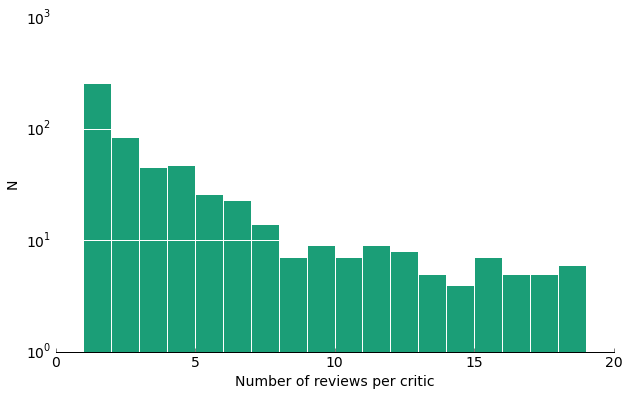

In [12]:
#Your code here
def histogram_style():
    remove_border(left=False)
    plt.grid(False)
    plt.grid(axis='y', color='w', linestyle='-', lw=1)

critics.groupby('critic').rtid.count().hist(log=True, bins=range(20), edgecolor='white')
plt.xlabel("Number of reviews per critic")
plt.ylabel("N")
histogram_style()

**2.3** List the 5 critics with the most reviews, along with the publication they write for

In [13]:
#Your code here
#note: there are a few valid ways to deal with critics that write for several publications.

counts = critics.groupby(['critic', 'publication']).critic.count()
counts.sort()
# from last the 5 ones and step = -1
counts[-1:-6:-1]


critic              publication      
Roger Ebert         Chicago Sun-Times    905
James Berardinelli  ReelViews            684
Janet Maslin        New York Times       437
Variety Staff       Variety              395
Jonathan Rosenbaum  Chicago Reader       362
Name: critic, dtype: int64

**2.4** Of the critics with > 100 reviews, plot the distribution of average "freshness" rating per critic

In [14]:
#Your code here

df = critics.copy()
df['fresh'] = df.fresh == 'fresh'
grp = df.groupby('critic')
counts = grp.critic.count()  # number of reviews by each critic
means = grp.fresh.mean()     # average freshness for each critic
means[counts > 100]

critic
Bosley Crowther       0.722689
Dave Kehr             0.615616
Derek Adams           0.590476
Desson Thomson        0.581395
Edward Guthmann       0.584158
Gene Siskel           0.784314
Geoff Andrew          0.733083
Hal Hinson            0.554140
James Berardinelli    0.595029
Janet Maslin          0.709382
Jay Boyar             0.688742
Jeff Millar           0.589552
John Hartl            0.672131
Jonathan Rosenbaum    0.593923
Kenneth Turan         0.610895
Kevin Thomas          0.814516
Lisa Schwarzbaum      0.666667
Michael Wilmington    0.659091
Mick LaSalle          0.531915
Mike Clark            0.465000
Owen Gleiberman       0.584071
Peter Stack           0.612903
Peter Travers         0.672646
Richard Corliss       0.772277
Richard Schickel      0.732143
Rick Groen            0.471154
Rita Kempley          0.524444
Roger Ebert           0.669447
Stephen Holden        0.486486
Susan Stark           0.572414
Susan Wloszczyna      0.383178
Todd McCarthy         0.684783
V

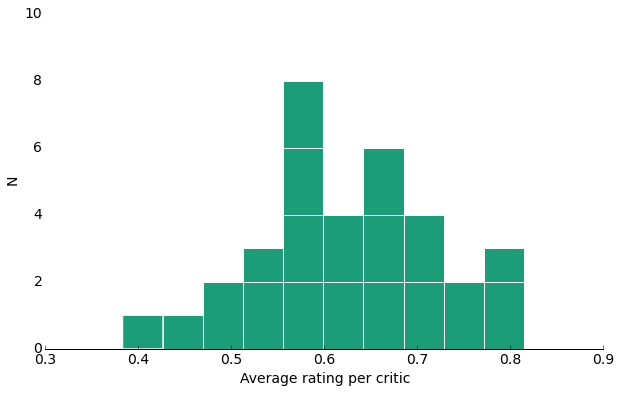

In [15]:
# plot rating (x) and number of critics (y)
means[counts > 100].hist(bins=10, edgecolor='w', lw=1)
plt.xlabel("Average rating per critic")
plt.ylabel("N")
plt.yticks([0, 2, 4, 6, 8, 10])
histogram_style()

**2.5**
Using the original `movies` dataframe, plot the rotten tomatoes Top Critics Rating as a function of year. Overplot the average for each year, ignoring the score=0 examples (some of these are missing data). Comment on the result -- is there a trend? What do you think it means?

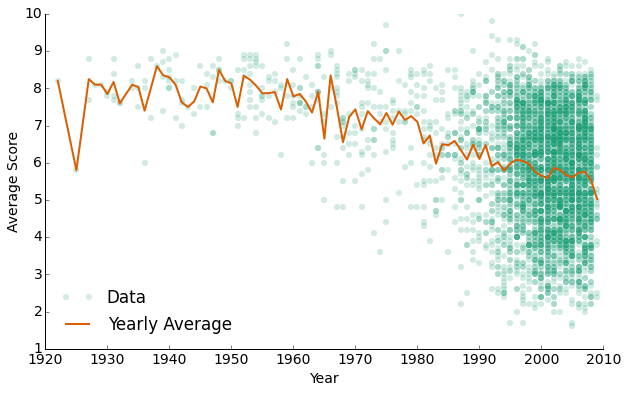

In [16]:
#Your code here

data = movies[['year', 'rtTopCriticsRating']]
data = data.convert_objects(convert_numeric=True)
data = data[(data['rtTopCriticsRating'] > 0)]
means = data.groupby('year').mean().dropna()

plt.plot(data['year'], data['rtTopCriticsRating'], 'o', mec='none', alpha=.2, label='Data')
plt.plot(means.index, means['rtTopCriticsRating'], '-', label='Yearly Average')
plt.legend(loc='lower left', frameon=False)
plt.xlabel("Year")
plt.ylabel("Average Score")
remove_border()

**Answer** *This graph shows a trend towards a lower average score, as well as a greater abundance of low scores, with time. This is probably at least partially a selection effect -- Rotten Tomatoes probably doesn't archive reviews for all movies, especially ones that came out before the website existed. Thus, reviews of old movies are more often "the classics". Mediocre old movies have been partially forgotten, and are underrepresented in the data.*

## Part 3: Sentiment Analysis

You will now use a [Naive Bayes classifier](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) to build a prediction model for whether a review is fresh or rotten, depending on the text of the review. See Naive Bayse Lecture for a discussion of Naive Bayes.

Most models work with numerical data, so we need to convert the textual collection of reviews to something numerical. A common strategy for text classification is to represent each review as a "bag of words" vector -- a long vector
of numbers encoding how many times a particular word appears in a blurb.

Scikit-learn has an object called a `CountVectorizer` that turns text into a bag of words. Here's a quick tutorial:

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['Hop on pop', 'Hop off pop', 'Hop Hop hop']
print "Original text is\n", '\n'.join(text)

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print
print "Transformed text vector is \n", x

# `get_feature_names` tracks which word is associated with each column of the transformed x
print
print "Words for each feature:"
print vectorizer.get_feature_names()

# Notice that the bag of words treatment doesn't preserve information about the *order* of words, 
# just their frequency

Original text is
Hop on pop
Hop off pop
Hop Hop hop

Transformed text vector is 
[[1 0 1 1]
 [1 1 0 1]
 [3 0 0 0]]

Words for each feature:
[u'hop', u'off', u'on', u'pop']


**3.1**

Using the `critics` dataframe, compute a pair of numerical X, Y arrays where:
    
 * X is an `(nreview, nwords)` array. Each row corresponds to a bag-of-words representation for a single review. This will be the *input* to your model.
 * Y is an `nreview`-element 1/0 array, encoding whether a review is Fresh (1) or Rotten (0). This is the desired *output* from your model.
 
Make sure to remove items with no review text

In [18]:
#hint: Consult the scikit-learn documentation to
#      learn about what these classes do do
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import MultinomialNB

"""
Function
--------
make_xy

Build a bag-of-words training set for the review data

Parameters
-----------
critics : Pandas DataFrame
    The review data from above
    
vectorizer : CountVectorizer object (optional)
    A CountVectorizer object to use. If None,
    then create and fit a new CountVectorizer.
    Otherwise, re-fit the provided CountVectorizer
    using the critics data
    
Returns
-------
X : numpy array (dims: nreview, nwords)
    Bag-of-words representation for each review.
Y : numpy array (dims: nreview)
    1/0 array. 1 = fresh review, 0 = rotten review

Examples
--------
X, Y = make_xy(critics)
"""
def make_xy(critics, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  # some versions of sklearn return COO format (Read about coordinate format)
    Y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, Y

In [19]:
X, Y = make_xy(critics)


**3.2** Next, randomly split the data into two groups: a
training set and a validation set. 

Use the training set to train a `MultinomialNB` classifier,
and print the accuracy of this model on the validation set

**Hint**
You can use `train_test_split` to split up the training data

In [20]:
#Your code here
xtrain, xtest, ytrain, ytest = train_test_split(X, Y)
clf = MultinomialNB().fit(xtrain, ytrain)

print "Accuracy: %0.2f%%" % (100 * clf.score(xtest, ytest))

Accuracy: 77.27%


**3.3:**

We say a model is **overfit** if it performs better on the training data than on the test data. Is this model overfit? If so, how much more accurate is the model on the training data compared to the test data?

In [21]:
# Your code here. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print "Accuracy on training data: %0.2f" % (training_accuracy)
print "Accuracy on test data:     %0.2f" % (test_accuracy)

Accuracy on training data: 0.93
Accuracy on test data:     0.77


*Interpret these numbers in a few sentences here*

**Answer** *Some overfitting seems to be happening here, since the error rate on the test data (23%) is more than twice as large as the error rate on the training data (10%). It's possible (though unlikely) that the accuracy difference is a product of chance, and not a symptom of overfitting. This could be tested with cross-validation, by repeatedly fitting and scoring the classifier on different train/test splits. If the performance on the training data is consistently better than the test data, then overfitting has occured. This is the case here.*

**3.4: Model Calibration**

Bayesian models like the Naive Bayes classifier have the nice property that they compute probabilities of a particular classification -- the `predict_proba` and `predict_log_proba` (log probability) methods of `MultinomialNB` compute these probabilities. 

Being the respectable Bayesian that you are, you should always assess whether these probabilities are **calibrated** -- that is, whether a prediction made with a confidence of `x%` is correct approximately `x%` of the time.

Let's make a plot to assess model calibration. Schematically, we want something like this:

<img src="http://i.imgur.com/ea5B6zr.png" width=500px>

In words, we want to:

* Take a collection of examples, and compute the freshness probability for each using `clf.predict_proba`
* Gather examples into bins of similar freshness probability (the diagram shows 5 groups -- you should use something closer to 20)
* For each bin, count the number of examples in that bin, and compute the fraction of examples in the bin which are fresh
* In the upper plot, graph the expected P(Fresh) (x axis) and observed freshness fraction (Y axis). Estimate the uncertainty in observed freshness fraction $F$ via the [equation](http://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval) $\sigma = \sqrt{F (1-F) / N}$ (F number of success/freshness and N number of samples)
* Overplot the line y=x. This is the trend we would expect if the model is calibrated
* In the lower plot, show the number of examples in each bin

**Hints**

The output of `clf.predict_proba(X)` is a `(N example, 2)` array. The first column gives the probability $P(Y=0)$ or  $P(Rotten)$, and the second gives $P(Y=1)$ or $P(Fresh)$.

The above image is just a guideline -- feel free to explore other options!

In [ ]:
"""
Function
--------
calibration_plot

Builds a plot like the one above, from a classifier and review data

Inputs
-------
clf : Classifier object
    A MultinomialNB classifier
X : (Nexample, Nfeature) array
    The bag-of-words data
Y : (Nexample) integer array
    1 if a review is Fresh
"""    
#your code here

def calibration_plot(clf, xtest, ytest):
    prob = clf.predict_proba(xtest)[:, 1]
    outcome = ytest
    data = pd.DataFrame(dict(prob=prob, outcome=outcome))

    #group outcomes into bins of similar probability
    bins = np.linspace(0, 1, 20)
    cuts = pd.cut(prob, bins)
    binwidth = bins[1] - bins[0]
    
    #freshness ratio and number of examples in each bin
    cal = data.groupby(cuts).outcome.agg(['mean', 'count'])
    cal['pmid'] = (bins[:-1] + bins[1:]) / 2
    cal['sig'] = np.sqrt(cal.pmid * (1 - cal.pmid) / cal['count'])
        
    #the calibration plot
    ax = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    p = plt.errorbar(cal.pmid, cal['mean'], cal['sig'])
    plt.plot(cal.pmid, cal.pmid, linestyle='--', lw=1, color='k')
    plt.ylabel("Empirical P(Fresh)")
    remove_border(ax)
    
    #the distribution of P(fresh)
    ax = plt.subplot2grid((3, 1), (2, 0), sharex=ax)
    
    plt.bar(left=cal.pmid - binwidth / 2, height=cal['count'],
            width=.95 * (bins[1] - bins[0]),
            fc=p[0].get_color())
    
    plt.xlabel("Predicted P(Fresh)")
    remove_border()
    plt.ylabel("Number")

In [ ]:
calibration_plot(clf, xtest, ytest)

**3.5** We might say a model is *over-confident* if the freshness fraction is usually closer to 0.5 than expected (that is, there is more uncertainty than the model predicted). Likewise, a model is *under-confident* if the probabilities are usually further away from 0.5. Is this model generally over- or under-confident? 

**Answer** *This model is over-confident. For a properly calibrated model, we would expect ~10% of the P(Fresh)~0.1 reviews to actually be fresh. However, the actual freshness rate is closer to 30%. Likewise, for reviews where P(Fresh) ~0.9, the actuall freshness fraction is closer to 0.7. In other words, there is more uncertainty in the outcome than implied by the model.*

#### Cross Validation

Our classifier has a few free parameters. The two most important are:

 1. The `min_df` keyword in `CountVectorizer`, which will ignore words which appear in fewer than `min_df` fraction of reviews. Words that appear only once or twice can lead to overfitting, since words which occur only a few times might correlate very well with Fresh/Rotten reviews by chance in the training dataset.
 
 2. The [`alpha` keyword](http://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes) in the Bayesian classifier is a "smoothing parameter" -- increasing the value decreases the sensitivity to any single feature, and tends to pull prediction probabilities closer to 50%. 

As discussed in lecture, a common technique for choosing appropriate values for these parameters is **cross-validation**. Let's choose good parameters by maximizing the cross-validated log-likelihood.

**3.6** Using `clf.predict_logproba`, write a function that computes the log-likelihood of a dataset

In [ ]:
"""
Function
--------
log_likelihood

Compute the log likelihood of a dataset according to 
a bayesian classifier. 
The Log Likelihood is defined by

L = Sum_fresh(logP(fresh)) + Sum_rotten(logP(rotten))

Where Sum_fresh indicates a sum over all fresh reviews, 
and Sum_rotten indicates a sum over rotten reviews
    
Parameters
----------
clf : Bayesian classifier
x : (nexample, nfeature) array
    The input data
y : (nexample) integer array
    Whether each review is Fresh
"""
#your code here

def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

Here's a function to estimate the cross-validated value of a scoring function, given a classifier and data

In [ ]:
from sklearn.cross_validation import KFold

def cv_score(clf, x, y, score_func):
    """
    Uses 5-fold cross validation to estimate a score of a classifier
    
    Inputs
    ------
    clf : Classifier object
    x : Input feature vector
    y : Input class labels
    score_func : Function like log_likelihood, that takes (clf, x, y) as input,
                 and returns a score
                 
    Returns
    -------
    The average score obtained by randomly splitting (x, y) into training and 
    test sets, fitting on the training set, and evaluating score_func on the test set
    
    Examples
    cv_score(clf, x, y, log_likelihood)
    """
    result = 0
    nfold = 5
    for train, test in KFold(y.size, nfold): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf, x[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

**3.7**

Fill in the remaining code in this block, to loop over many values of `alpha` and `min_df` to determine
which settings are "best" in the sense of maximizing the cross-validated log-likelihood

In [ ]:
#the grid of parameters to search over
alphas = [0, .1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
max_loglike = -np.inf

for alpha in alphas:
    for min_df in min_dfs:         
        vectorizer = CountVectorizer(min_df = min_df)       
        X, Y = make_xy(critics, vectorizer)
        
        #your code here
        clf = MultinomialNB(alpha=alpha)
        loglike = cv_score(clf, X, Y, log_likelihood) # log probability function, defined already

        if loglike > max_loglike:
            max_loglike = loglike
            best_alpha, best_min_df = alpha, min_df

In [ ]:
print "alpha: %f" % best_alpha
print "min_df: %f" % best_min_df

**3.8** Now that you've determined values for alpha and min_df that optimize the cross-validated log-likelihood, repeat the steps in 3.1, 3.2, and 3.4 to train a final classifier with these parameters, re-evaluate the accuracy, and draw a new calibration plot.

In [ ]:
#Your code here

vectorizer = CountVectorizer(min_df=best_min_df)
X, Y = make_xy(critics, vectorizer)
xtrain, xtest, ytrain, ytest = train_test_split(X, Y)

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

calibration_plot(clf, xtest, ytest)

# Your code here. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print "Accuracy on training data: %0.2f" % (training_accuracy)
print "Accuracy on test data:     %0.2f" % (test_accuracy)

**3.9** Discuss the various ways in which Cross-Validation has affected the model. Is the new model more or less accurate? Is overfitting better or worse? Is the model more or less calibrated?

**Answer** *The new model is slightly less accurate on the test data (74% vs 77% on the original model). However, it is both better calibrated and less over-fit than before. In other words, while the classification accuracy is slightly worse, the probabilities themselves are more accurate. The model is still slightly over-confident when making low P(Fresh) predictions. However, the calibration plot shows the model is usually within 1 error bar of the expected performance where P(Fresh) >= 0.2. Finally, the new model makes less-conclusive predictions on average -- the histogram in the calibration plot is more uniformly distributed, with fewer predictions clustered around P(Fresh) = 0 or 1.*

*To think about/play with, but not to hand in: What would happen if you tried this again using a function besides the log-likelihood -- for example, the classification accuracy?*

### Part 4: Interpretation. What words best predict a fresh or rotten review?

**4.1**
Using your classifier and the `vectorizer.get_feature_names` method, determine which words best predict a positive or negative review. Print the 10 words
that best predict a "fresh" review, and the 10 words that best predict a "rotten" review. For each word, what is the model's probability of freshness if the word appears one time?

#### Hints

* Try computing the classification probability for a feature vector which consists of all 0s, except for a single 1. What does this probability refer to?

* `np.eye` generates a matrix where the ith row is all 0s, except for the ith column which is 1.

In [ ]:
## Your code here

words = np.array(vectorizer.get_feature_names())
# xtest.shape[1] give second dimension that is the words and make it eye
x = np.eye(xtest.shape[1])
# predict on each word
probs = clf.predict_log_proba(x)[:, 0]
# sort based on index of each word
ind = np.argsort(probs)

# get first 10
good_words = words[ind[:10]]
# get last 10 
bad_words = words[ind[-10:]]

# get probabilities based on index for first and last 10
good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print "Good words\t     P(fresh | word)"
for w, p in zip(good_words, good_prob):
    print "%20s" % w, "%0.2f" % (1 - np.exp(p))
    
print "Bad words\t     P(fresh | word)"
for w, p in zip(bad_words, bad_prob):
    print "%20s" % w, "%0.2f" % (1 - np.exp(p))

**4.2**

One of the best sources for inspiration when trying to improve a model is to look at examples where the model performs poorly. 

Find 5 fresh and rotten reviews where your model performs particularly poorly. Print each review.

In [ ]:
#Your code here
x, y = make_xy(critics, vectorizer)

prob = clf.predict_proba(x)[:, 0]
predict = clf.predict(x)

bad_rotten = np.argsort(prob[y == 0])[:5]
bad_fresh = np.argsort(prob[y == 1])[-5:]

print "Mis-predicted Rotten quotes"
print '---------------------------'
for row in bad_rotten:
    print critics[y == 0].quote.irow(row)
    print

print "Mis-predicted Fresh quotes"
print '--------------------------'
for row in bad_fresh:
    print critics[y == 1].quote.irow(row)
    print




**4.3** What do you notice about these mis-predictions? Naive Bayes classifiers assume that every word affects the probability independently of other words. In what way is this a bad assumption? In your answer, report your classifier's Freshness probability for the review "This movie is not remarkable, touching, or superb in any way".

In [ ]:
clf.predict_proba(vectorizer.transform(['This movie is not remarkable, touching, or superb in any way']))

**Answer** *Many mis-predictions seem due to the fact that the quotes use more ambivalent language -- quotes along the lines of "this should have been a good movie, but it wasn't". Words like "but", "not", etc. act to negate the sentiment of words. However, because Naive Bayes treats each word separately, it isn't able to capture these kind of word interactions. Because the quote "this movie is not remarkable, touching, or superb in any way" contains typically positive words like remarkabke/touching/superb, the classifier gives it P(Fresh)=0.98.*

**4.4**
If this was your final project, what are 3 things you would try in order to build a more effective review classifier? What other exploratory or explanatory visualizations do you think might be helpful?

There are many things worth trying. Some examples:

1. You could try to build a NB model where the features are word pairs instead of words. This would be smart enough to realize that "not good" and "so good" mean very different things. This technique doesn't scale very well, since these features are much more sparse (and hence harder to detect repeatable patterns within).
2. You could try a model besides NB, that would allow for interactions between words -- for example, a Random Forest classifier.
3. You could consider adding supplemental features -- information about genre, director, cast, etc.
4. You could build a visualization that prints word reviews, and visually encodes each word with size or color to indicate how that word contributes to P(Fresh). For example, really bad words could show up as big and red, good words as big and green, common words as small and grey, etc.